In [1]:
import pm4py
log_all = pm4py.read_xes('BPI_Challenge_2019.xes')

parsing log, completed traces ::   0%|          | 0/251734 [00:00<?, ?it/s]

In [2]:
last_timestamp = max(event["time:timestamp"] for trace in log_all for event in trace)
print("Last Timestamp:", last_timestamp)
first_timestamp = min(event["time:timestamp"] for trace in log_all for event in trace)
print("First Timestamp:", first_timestamp)

time_filtered_log = pm4py.filter_time_range(log_all, "2018-09-01 00:00:00", "2018-12-01 00:00:00", mode='traces_contained')

Last Timestamp: 2020-04-09 21:59:00+00:00
First Timestamp: 1948-01-26 22:59:00+00:00


In [3]:
print(f'activities: {list(pm4py.get_event_attribute_values(time_filtered_log,"concept:name").keys())}')
print("Number of different trace variants: ", len(pm4py.get_variants_as_tuples(time_filtered_log)))

activities: ['Create Purchase Order Item', 'Delete Purchase Order Item', 'Vendor creates invoice', 'Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice', 'Remove Payment Block', 'Cancel Goods Receipt', 'Change Quantity', 'Vendor creates debit memo', 'Cancel Invoice Receipt', 'Change Price', 'Receive Order Confirmation', 'Change Storage Location', 'Change Delivery Indicator', 'Block Purchase Order Item', 'Create Purchase Requisition Item', 'Reactivate Purchase Order Item', 'Record Service Entry Sheet', 'SRM: Created', 'SRM: Complete', 'SRM: Awaiting Approval', 'SRM: Document Completed', 'SRM: Ordered', 'SRM: In Transfer to Execution Syst.', 'SRM: Change was Transmitted', 'SRM: Deleted', 'SRM: Transaction Completed', 'Cancel Subsequent Invoice', 'Change Approval for Purchase Order', 'Release Purchase Order', 'Update Order Confirmation', 'Record Subsequent Invoice', 'Change payment term', 'Change Final Invoice Indicator', 'Set Payment Block']
Number of different trace variants

In [4]:
from exdpn.petri_net import get_petri_net
log = pm4py.filter_event_attribute_values(
    time_filtered_log,
    "concept:name",
    ['Create Purchase Order Item', 'Vendor creates invoice', 'Record Goods Receipt', 'Record Invoice Receipt', 
    'Clear Invoice', 'Record Service Entry Sheet', 'Cancel Goods Receipt', 
    'Vendor creates debit memo', 'Cancel Invoice Receipt', 'Change Delivery Indicator', 'Remove Payment Block', 
    'Change Price', 'Delete Purchase Order Item', 'Change Quantity', 
    'Change Final Invoice Indicator', 'Receive Order Confirmation', 'Cancel Subsequent Invoice', 
    'Reactivate Purchase Order Item', 'Update Order Confirmation', 'Block Purchase Order Item', 
    'Change Approval for Purchase Order', 'Release Purchase Order', 'Record Subsequent Invoice', 'Set Payment Block', 
    'Create Purchase Requisition Item', 'Change Storage Location', 'Change Currency', 'Change payment term', 
    'Change Rejection Indicator', 'Release Purchase Requisition'],
    level="event",
    retain=True)

print("Number of different trace variants - subtraces: ", len(pm4py.get_variants_as_tuples(log)))



Number of different trace variants - subtraces:  1535


In [5]:
log_start = pm4py.get_start_activities(log)
print(log_start)
filtered_log = pm4py.filter_start_activities(log, 'Create Purchase Order Item')
print("Number of different trace variants - subtraces: ", len(pm4py.get_variants_as_tuples(filtered_log)))

end_activities = pm4py.get_end_activities(log)
print(end_activities)
filtered_log = pm4py.filter_end_activities(log, ["Clear Invoice"])

print("Number of different trace variants - subtraces: ", len(pm4py.get_variants_as_tuples(filtered_log)))

{'Create Purchase Order Item': 11176, 'Vendor creates invoice': 347, 'Vendor creates debit memo': 3, 'Create Purchase Requisition Item': 14665, 'Release Purchase Order': 1, 'Change Approval for Purchase Order': 13}
Number of different trace variants - subtraces:  959
{'Delete Purchase Order Item': 1850, 'Clear Invoice': 10521, 'Create Purchase Order Item': 1521, 'Cancel Goods Receipt': 175, 'Record Goods Receipt': 4576, 'Record Invoice Receipt': 5316, 'Receive Order Confirmation': 123, 'Change Delivery Indicator': 104, 'Block Purchase Order Item': 17, 'Record Service Entry Sheet': 401, 'Change Approval for Purchase Order': 211, 'Change Quantity': 107, 'Change Storage Location': 15, 'Change Price': 48, 'Remove Payment Block': 1187, 'Release Purchase Order': 1, 'Change payment term': 1, 'Cancel Subsequent Invoice': 4, 'Cancel Invoice Receipt': 1, 'Record Subsequent Invoice': 1, 'Vendor creates invoice': 23, 'Update Order Confirmation': 1, 'Set Payment Block': 1}
Number of different trace

In [6]:
# We discard less frequent variants in order to reduce
# the number of edge cases.
log = pm4py.filter_variants_top_k(filtered_log, 10)

pm4py.write_xes(log, "BPI_Challenge_2019_filtered_top_k.xes")
len(log)

exporting log, completed traces ::   0%|          | 0/8345 [00:00<?, ?it/s]

8345

### Analysis

In [7]:
import pm4py
log = pm4py.read_xes("BPI_Challenge_2019_filtered_top_k.xes")

parsing log, completed traces ::   0%|          | 0/8345 [00:00<?, ?it/s]

In [8]:
from exdpn.petri_net import get_petri_net
net, im, fm = get_petri_net(log, miner_type='IM')

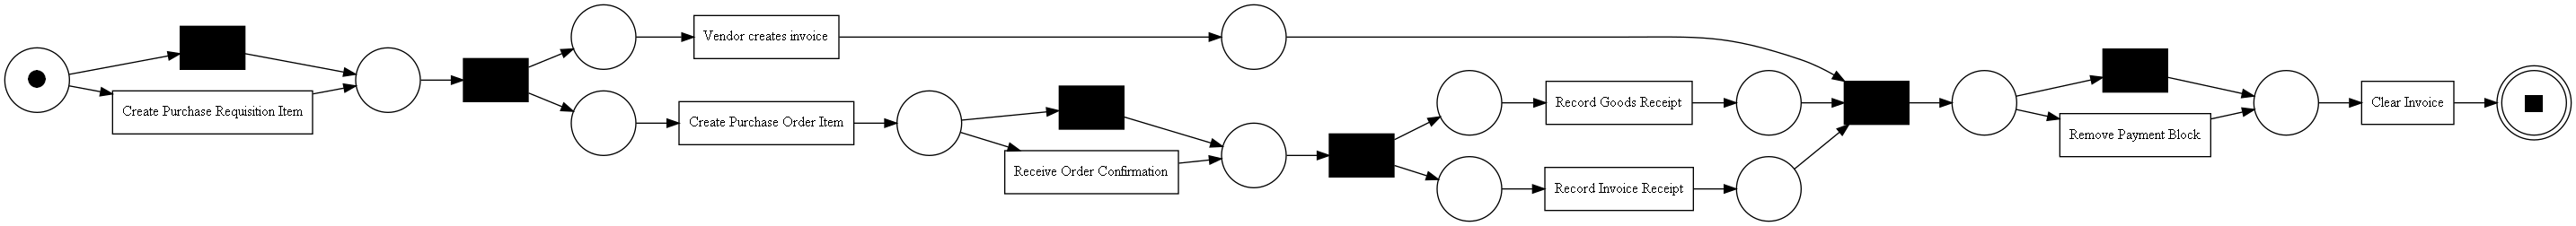

In [9]:
pm4py.view_petri_net(net, im, fm)

In [10]:
event_attrs = list(pm4py.get_event_attributes(log))
trace_attrs = list(pm4py.get_trace_attributes(log))

In [11]:
event_attrs = [attr for attr in event_attrs if max(list(pm4py.get_event_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
event_attrs.remove("time:timestamp")
event_attrs.remove("org:resource")
event_attrs.remove("User")
event_attrs

['concept:name', 'Cumulative net worth (EUR)']

In [12]:
trace_attrs = [attr for attr in trace_attrs if max(list(pm4py.get_trace_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
trace_attrs.remove("Name")
trace_attrs.remove("Item")
trace_attrs.remove("Purchasing Document")
trace_attrs

['Company',
 'Spend area text',
 'Sub spend area text',
 'GR-Based Inv. Verif.',
 'Document Type',
 'Vendor',
 'Goods Receipt',
 'Source',
 'Item Type',
 'Item Category',
 'Purch. Doc. Category name',
 'Spend classification text']

#### Decision Trees without hyperparameter:

In [13]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     hyperparameters={ML_Technique.DT: {}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_9'... Done
-> Evaluating guards at decision point 'source'... Done
-> Evaluating guards at decision point 'p_4'... Done


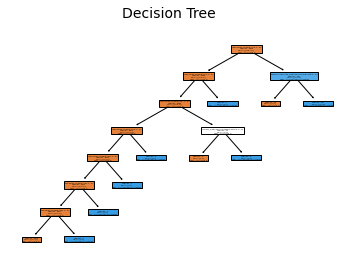

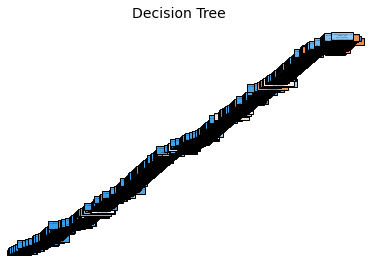

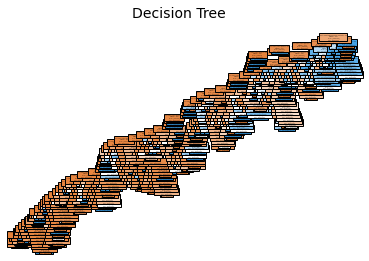

In [14]:
dps = list(dpn.decision_points)
for p in dps:
    dt_guard = dpn.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()

### Data Petri Net with hyperparameter:

In [16]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.LR, ML_Technique.NN, ML_Technique.SVM, ML_Technique.RF]#, ML_Technique.XGB]

dpn_hp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True,
                     hyperparameters = {ML_Technique.NN: {'hidden_layer_sizes': (10,5), 'learning_rate_init': 0.0001, 'alpha': 0.0001, 'max_iter': 2000},
                                        ML_Technique.DT: {'min_impurity_decrease': 0.0075},
                                        ML_Technique.LR: {'C': 0.1375, 'tol': 0.001},
                                        ML_Technique.SVM: {'C': 0.3, 'tol': 0.001},
                                        ML_Technique.RF:  {'max_depth': 5}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_9'... Done
-> Evaluating guards at decision point 'source'... 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Done
-> Evaluating guards at decision point 'p_4'... 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Done


In [17]:
import re
from exdpn.guards import Guard_Manager

# model xgb separatly due to special characters in the data sets
xgb_hp_gm = {}

# data sets contain special characters which xgb boost cannot handel
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
for dp in list(dpn_hp.decision_points):
    dp_dataset = dpn_hp.guard_ds_per_place[dp]
    dp_gm_hp = Guard_Manager(dp_dataset,
                          ml_list=[ML_Technique.XGB],
                          hyperparameters={ML_Technique.XGB: {'max_depth': 2, 'n_estimators': 50}},
                          impute=True)
    # remove special characters
    # solution from: https://stackoverflow.com/questions/48645846/pythons-xgoost-valueerrorfeature-names-may-not-contain-or
    for col in dp_gm_hp.df_X:
        dp_gm_hp.df_X[col] = [regex.sub("_", value) if any(x in str(value) for x in set(('[', ']', '<'))) else value for value in dp_gm_hp.df_X[col]]

    dp_gm_hp.train_test()
    xgb_hp_gm[dp] = dp_gm_hp.f1_mean_test[ML_Technique.XGB]

In [18]:
import pandas as pd

res_hp = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn_hp.guard_manager_per_place.items():
    res_row = {"place":dp} | {str(ml_t):gm.f1_mean_test[ml_t] for ml_t in gm.guards_list.keys()}
    res_hp = res_hp.append([res_row])

res_hp['place'] = res_hp['place'].apply(str)
res_hp.index = res_hp["place"]
res_hp.drop(["place"], axis=1, inplace=True)
res_hp.dropna(axis=1, how="all", inplace=True)

# xgb results
res_hp_xgb = pd.DataFrame(columns=["place"] + [str(ML_Technique.XGB)])
for dp, result in xgb_hp_gm.items():
    res_hp_xgb = res_hp_xgb.append([{"place":dp} | {str(ML_Technique.XGB):result}])

res_hp_xgb['place'] = res_hp_xgb['place'].apply(str)
res_hp_xgb.index = res_hp_xgb["place"]
res_hp_xgb.drop(["place"], axis=1, inplace=True)
res_hp_xgb.dropna(axis=1, how="all", inplace=True)

res_hp_complete = pd.concat([res_hp, res_hp_xgb], axis = 1)
res_hp_complete.transpose()

place,p_9,source,p_4
Decision Tree,0.995218,0.690963,0.874570
Logistic Regression,0.997931,0.756306,0.847340
Neural Network,0.994754,0.858604,0.827875
Support Vector Machine,0.997826,0.838373,0.830718
Random Forest,0.970981,0.668434,0.835994
XGBoost,0.995707,0.711979,0.841358


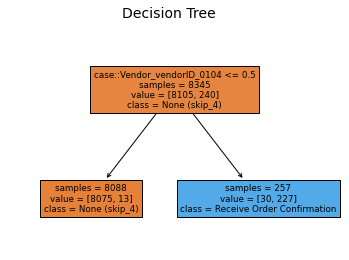

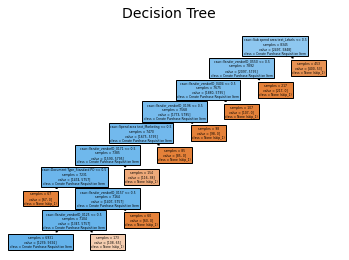

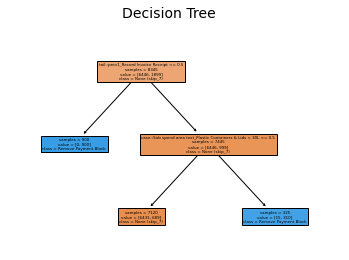

In [19]:
dps_hp = list(dpn_hp.decision_points)
for p in dps_hp:
    dt_guard = dpn_hp.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()